# 01 · S3WD-GWB 动态循环实验（Airline）


In [1]:
# Step 0 · 环境初始化与依赖检查
from __future__ import annotations

import json
import math
import os
import sys
import platform
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 50)

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

RUNTIME_INFO = {
    'python': sys.version.split()[0],
    'platform': platform.platform(),
    'project_root': str(PROJECT_ROOT),
}
print('【步骤0摘要】已初始化运行环境：', RUNTIME_INFO)



【步骤0摘要】已初始化运行环境： {'python': '3.11.5', 'platform': 'Windows-10-10.0.26100-SP0', 'project_root': 'E:\\yan\\组\\三支决策\\机器学习\\C三支决策与不平衡数据集分类\\S3WD实验'}


In [2]:
# Step 1 · 载入配置并展开变量
from s3wdlib.config_loader import load_yaml_cfg, extract_vars, show_cfg

CONFIG_PATH = PROJECT_ROOT / 'configs' / 's3wd_airline_dynamic.yaml'
CFG = load_yaml_cfg(str(CONFIG_PATH))
V = extract_vars(CFG)
show_cfg(CFG)
print('【步骤1摘要】配置文件加载完成，关键键数=', len(V))



【配置快照】
- DATA: {'data_dir': '../data', 'data_file': 'airlines_train_regression_1000000.arff', 'continuous_label': 'DepDelay', 'threshold': 15, 'threshold_op': '>', 'test_size': 0.3, 'val_size': 0.3, 'random_state': 42}
- LEVEL: {'level_pcts': [0.6, 0.8, 1.0], 'ranker': 'mi'}
- KWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'use_faiss': True, 'faiss_gpu': True}
- GWB: {'k': 6, 'metric': 'euclidean', 'eps': 1e-06, 'mode': 'epanechnikov', 'bandwidth': 0.8, 'bandwidth_scale': 1.0, 'use_faiss': True, 'faiss_gpu': True}
- S3WD: {'c1': 0.37, 'c2': 0.63, 'xi_min': 0.1, 'theta_pos': 0.9, 'theta_neg': 0.1, 'sigma': 3.0, 'regret_mode': 'utility', 'penalty_large': 1000000.0, 'gamma_last': True, 'gap': 0.02}
- PSO: {'particles': 20, 'iters': 20, 'w_max': 0.9, 'w_min': 0.4, 'c1': 2.8, 'c2': 1.3, 'seed': 42, 'use_gpu': True}
- DYN: {'strategy': 'windowed_pso', 'step': 256, 'window_size': 512, 'target_bnd': 0.18, 'ema_alpha': 0.6, 'median_window': 3, 'keep_gap': 0.02, 'fallback_rule': True, 'gamma

In [3]:
# Step 2 · 加载数据集并准备标签
from s3wdlib.data_io import load_table_auto
from sklearn.datasets import make_classification

raw_data_path = Path(V['DATA_PATH'])
if not raw_data_path.is_absolute():
    data_path = (CONFIG_PATH.parent / raw_data_path).resolve()
else:
    data_path = raw_data_path

def _assign_year_and_sort(features, target, start_year):
    month_candidates = ['Month', 'month']
    day_candidates = ['DayofMonth', 'DayOfMonth', 'dayofmonth']
    month_col = next((c for c in month_candidates if c in features.columns), None)
    day_col = next((c for c in day_candidates if c in features.columns), None)
    if month_col is None or day_col is None:
        return features.reset_index(drop=True), target.reset_index(drop=True)
    df = features.copy()
    months = pd.to_numeric(df[month_col], errors='coerce').fillna(method='ffill').fillna(method='bfill').fillna(1).astype(int)
    days = pd.to_numeric(df[day_col], errors='coerce').fillna(1).astype(int)
    current_year = int(start_year)
    years = []
    prev_month = None
    for m in months:
        if prev_month is not None and m < prev_month:
            current_year += 1
        years.append(current_year)
        prev_month = m
    df['Year'] = years
    df[month_col] = months
    df[day_col] = days
    combined = df.assign(__target__=target.values)
    combined.sort_values(by=['Year', month_col, day_col], inplace=True, kind='mergesort')
    sorted_features = combined.drop(columns='__target__').reset_index(drop=True)
    sorted_target = combined['__target__'].reset_index(drop=True)
    return sorted_features, sorted_target

start_year_cfg = int(V.get('DATA_START_YEAR', 2018))
if data_path.exists():
    X_df, y_sr = load_table_auto(
        str(data_path),
        label_col=V.get('LABEL_COL'),
        positive_label=V.get('POSITIVE_LABEL', 1),
        continuous_label=V.get('CONT_LABEL'),
        threshold=V.get('CONT_THRESH'),
        threshold_op=V.get('CONT_OP', '>='),
    )
    X_df, y_sr = _assign_year_and_sort(X_df, y_sr, start_year=start_year_cfg)
    data_source = f'航空延误真实数据: {data_path.name}'
else:
    n_samples = 12000
    n_features = 32
    X_arr, y_arr = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=18,
        n_redundant=6,
        n_repeated=0,
        n_clusters_per_class=2,
        weights=[0.6, 0.4],
        class_sep=1.2,
        random_state=int(V.get('SEED', 42)),
    )
    X_df = pd.DataFrame(X_arr, columns=[f'feat_{i:02d}' for i in range(n_features)])
    y_sr = pd.Series(y_arr, name='label')
    data_source = '合成数据 (make_classification) 用于演示'
    print(f'⚠️ 未找到航空数据，自动生成 {n_samples} 条合成样本。')

if data_source.startswith('航空') and {'Year', 'Month'}.issubset(X_df.columns):
    first_year = int(X_df['Year'].iloc[0])
    first_month = int(X_df['Month'].iloc[0])
    last_year = int(X_df['Year'].iloc[-1])
    last_month = int(X_df['Month'].iloc[-1])
    time_span = f'{first_year}-{first_month:02d}~{last_year}-{last_month:02d}'
else:
    time_span = 'N/A'

print('【步骤2摘要】数据来源：', data_source, '；样本形状=', X_df.shape, '；时间跨度=', time_span)



【数据加载完毕】样本数=1000000，特征数=9，正类比例=0.1559
【步骤2摘要】数据来源： 航空延误真实数据: airlines_train_regression_1000000.arff ；样本形状= (1000000, 9)


In [4]:
# Step 3 · 按配置划分训练/验证/测试集
test_size = float(V['TEST_SIZE'])
val_size = float(V['VAL_SIZE'])
seed = int(V['SEED'])

total_samples = len(X_df)
test_count = int(round(total_samples * test_size))
test_count = min(max(test_count, 1), max(total_samples - 1, 1))
train_count = max(total_samples - test_count, 1)

split_index = train_count
X_train_full = X_df.iloc[:split_index].copy()
y_train_full = y_sr.iloc[:split_index].copy()
X_test = X_df.iloc[split_index:].copy()
y_test = y_sr.iloc[split_index:].copy()

val_fraction = float(val_size)
if val_fraction > 0 and len(X_train_full) > 1:
    val_count = int(round(len(X_train_full) * val_fraction))
    if val_count <= 0:
        val_count = 1
    if val_count >= len(X_train_full):
        val_count = max(len(X_train_full) // 5, 1)
    X_val = X_train_full.iloc[-val_count:].copy()
    y_val = y_train_full.iloc[-val_count:].copy()
    X_train_sub = X_train_full.iloc[:-val_count].copy()
    y_train_sub = y_train_full.iloc[:-val_count].copy()
else:
    X_val = X_train_full.iloc[0:0].copy()
    y_val = y_train_full.iloc[0:0].copy()
    X_train_sub = X_train_full.copy()
    y_train_sub = y_train_full.copy()

print('【步骤3摘要】训练/验证/测试规模=', len(X_train_sub), len(X_val), len(X_test))



【步骤3摘要】训练/验证/测试规模= 490000 210000 300000


In [5]:
# Step 4 · 数据适配与特征分层
from sklearn.preprocessing import StandardScaler
from s3wdlib.features import rank_features_mi, make_levels

CYCLIC_PERIODS = {
    'month': 12,
    'dayofmonth': 31,
    'day_of_month': 31,
    'dayofweek': 7,
    'day_of_week': 7,
    'weekday': 7,
}

def _detect_feature_roles(df: pd.DataFrame) -> Tuple[List[str], List[str], List[str]]:
    continuous, cyclic, categorical = [], [], []
    for col in df.columns:
        name = col.lower()
        series = df[col]
        if name in CYCLIC_PERIODS or any(key in name for key in ('time', 'hour', 'minute', 'week')):
            cyclic.append(col)
            continue
        if series.dtype.kind in 'O' or str(series.dtype).startswith('category'):
            categorical.append(col)
            continue
        nunique = series.nunique(dropna=True)
        if series.dtype.kind in 'iu' and nunique <= 12:
            categorical.append(col)
        else:
            continuous.append(col)
    return continuous, cyclic, categorical

def _encode_cyclic(series: pd.Series, period: float | None, treat_as_time: bool = False) -> pd.DataFrame:
    values = pd.to_numeric(series, errors='coerce').fillna(0.0)
    if treat_as_time:
        hours = (values // 100).astype(int) % 24
        minutes = (values % 100).astype(int) % 60
        values = hours * 60 + minutes
        period = 24 * 60
    period = float(period) if period and period > 0 else float(max(series.nunique(dropna=True), 1))
    angle = 2 * np.pi * (values % period) / period
    return pd.DataFrame(
        {
            f'{series.name}__sin': np.sin(angle),
            f'{series.name}__cos': np.cos(angle),
        },
        index=series.index,
    )

def _target_encoding(train_col: pd.Series, y: pd.Series, prior: float) -> Dict[str, float]:
    temp = pd.DataFrame({'value': train_col.fillna('__MISSING__').astype(str), 'y': y})
    stats = temp.groupby('value')['y'].agg(['count', 'mean'])
    smoothing = 1.0 / (1.0 + np.exp(-(stats['count'] - 20) / 5.0))
    enc = prior * (1.0 - smoothing) + stats['mean'] * smoothing
    return enc.to_dict()

cont_cols, cyc_cols, cat_cols = _detect_feature_roles(X_train_sub)
monitor_columns = list(dict.fromkeys(cont_cols + cyc_cols + cat_cols))
continuous_impute = {col: float(X_train_sub[col].median()) for col in cont_cols}
scaler = StandardScaler()
if cont_cols:
    scaler.fit(X_train_sub[cont_cols].fillna(continuous_impute).astype(float))
else:
    scaler = None

target_prior = float(y_train_sub.mean())
target_maps = {col: _target_encoding(X_train_sub[col], y_train_sub, target_prior) for col in cat_cols}

def transform_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    frames: List[pd.DataFrame] = []
    if cont_cols:
        cont_values = df[cont_cols].fillna(continuous_impute).astype(float)
        cont_scaled = scaler.transform(cont_values)
        frames.append(pd.DataFrame(cont_scaled, columns=[f'{c}__z' for c in cont_cols], index=df.index))
    if cyc_cols:
        cyc_frames = []
        for col in cyc_cols:
            lower = col.lower()
            period = CYCLIC_PERIODS.get(lower)
            treat_as_time = 'time' in lower and period is None
            cyc_frames.append(_encode_cyclic(df[col], period, treat_as_time=treat_as_time))
        frames.append(pd.concat(cyc_frames, axis=1))
    if cat_cols:
        encoded = {}
        for col in cat_cols:
            mapping = target_maps[col]
            encoded[f'{col}__te'] = df[col].fillna('__MISSING__').astype(str).map(mapping).fillna(target_prior).astype(float)
        frames.append(pd.DataFrame(encoded, index=df.index))
    transformed = pd.concat(frames, axis=1) if frames else pd.DataFrame(index=df.index)
    monitor = df[monitor_columns].copy()
    categories = df[cat_cols].fillna('__MISSING__') if cat_cols else pd.DataFrame(index=df.index)
    return transformed, monitor, categories

def make_event_dates(df: pd.DataFrame) -> pd.Series:
    required = {'Year', 'Month', 'DayofMonth'}
    if not required.issubset(df.columns):
        return pd.Series(pd.NaT, index=df.index, name='event_date')
    years = pd.to_numeric(df['Year'], errors='coerce').fillna(method='ffill').fillna(method='bfill').fillna(df['Year'].median())
    months = pd.to_numeric(df['Month'], errors='coerce').fillna(method='ffill').fillna(method='bfill').fillna(1)
    days = pd.to_numeric(df['DayofMonth'], errors='coerce').fillna(1)
    years = years.astype(int)
    months = months.astype(int)
    days = days.clip(lower=1, upper=31).astype(int)
    return pd.to_datetime({'year': years, 'month': months, 'day': days}, errors='coerce')

Xtr2, monitor_raw_tr, cat_train_sub = transform_dataset(X_train_sub)
Xva2, monitor_raw_va, cat_val = transform_dataset(X_val)
Xte2, monitor_raw_te, cat_test = transform_dataset(X_test)
Xtr_full2, monitor_raw_full, cat_train_full = transform_dataset(X_train_full)

EVENT_DATES_TRAIN = make_event_dates(X_train_sub)
EVENT_DATES_VAL = make_event_dates(X_val)
EVENT_DATES_TEST = make_event_dates(X_test)

feat_rank, feat_scores = rank_features_mi(Xtr2, y_train_sub)
L1, L2, L3 = make_levels(feat_rank, V.get('LEVEL_PCTS', [0.6, 0.8, 1.0]))

print('【步骤4摘要】数据适配完成：连续={}，周期={}，类别={}，监控字段={}，特征维度={}'.format(
    len(cont_cols), len(cyc_cols), len(cat_cols), len(monitor_columns), Xtr2.shape[1]
))



【步骤4摘要】数据适配完成：连续=4，周期=5，类别=0，监控字段=9，特征维度=14


In [6]:
# Step 5 · 拟合 GWB 三层概率估计器
from s3wdlib.gwb import GWBProbEstimator

def ensure_prob_1d(values) -> np.ndarray:
    arr = np.asarray(values, dtype=float)
    if arr.ndim == 2:
        if arr.shape[1] == 1:
            arr = arr[:, 0]
        else:
            arr = arr[:, -1]
    return arr.ravel()

gwb_kwargs = {
    'k': int(V['GWB_K']),
    'mode': V.get('GWB_mode', 'epanechnikov'),
    'bandwidth': V.get('GWB_bandwidth'),
    'bandwidth_scale': V.get('GWB_bandwidth_scale', 1.0),
    'use_faiss': bool(V.get('GWB_use_faiss', True)),
    'faiss_gpu': bool(V.get('GWB_faiss_gpu', True)),
}
if V.get('GWB_categorical_features') is not None:
    gwb_kwargs['categorical_features'] = list(V['GWB_categorical_features'])
if V.get('GWB_category_penalty') is not None:
    gwb_kwargs['category_penalty'] = float(V['GWB_category_penalty'])

gwb_kwargs = {k: v for k, v in gwb_kwargs.items() if v is not None}

CATEGORICAL_KERNEL_COLS = [
    col for col in gwb_kwargs.get('categorical_features', []) if col in cat_train_sub.columns
]

def _cat_slice(df: pd.DataFrame | None) -> pd.DataFrame | None:
    if df is None or not CATEGORICAL_KERNEL_COLS:
        return None
    return df[CATEGORICAL_KERNEL_COLS]

cat_train_slice = _cat_slice(cat_train_sub)
cat_val_slice = _cat_slice(cat_val)
cat_test_slice = _cat_slice(cat_test)

CAT_KERNEL_TRAIN = cat_train_slice
CAT_KERNEL_VAL = cat_val_slice
CAT_KERNEL_TEST = cat_test_slice

gwb_L1 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L1], y_train_sub.values, categorical_values=cat_train_slice)
gwb_L2 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L2], y_train_sub.values, categorical_values=cat_train_slice)
gwb_L3 = GWBProbEstimator(**gwb_kwargs).fit(Xtr2[L3], y_train_sub.values, categorical_values=cat_train_slice)

def _predict_estimator(estimator, X_part, cat_part):
    if cat_part is not None:
        return estimator.predict_proba(X_part, categorical_values=cat_part)
    return estimator.predict_proba(X_part)

p1_val = ensure_prob_1d(_predict_estimator(gwb_L1, Xva2[L1], cat_val_slice))
p2_val = ensure_prob_1d(_predict_estimator(gwb_L2, Xva2[L2], cat_val_slice))
p3_val = ensure_prob_1d(_predict_estimator(gwb_L3, Xva2[L3], cat_val_slice))

p1_test = ensure_prob_1d(_predict_estimator(gwb_L1, Xte2[L1], cat_test_slice))
p2_test = ensure_prob_1d(_predict_estimator(gwb_L2, Xte2[L2], cat_test_slice))
p3_test = ensure_prob_1d(_predict_estimator(gwb_L3, Xte2[L3], cat_test_slice))

p1_train = ensure_prob_1d(_predict_estimator(gwb_L1, Xtr2[L1], cat_train_slice))
p2_train = ensure_prob_1d(_predict_estimator(gwb_L2, Xtr2[L2], cat_train_slice))
p3_train = ensure_prob_1d(_predict_estimator(gwb_L3, Xtr2[L3], cat_train_slice))

TRAIN_PROBS = {'L1': p1_train, 'L2': p2_train, 'L3': p3_train}

print('【步骤5摘要】训练/验证/测试概率均值(L1)={:.4f}/{:.4f}/{:.4f}'.format(float(np.mean(p1_train)), float(np.mean(p1_val)), float(np.mean(p1_test))))



【步骤5摘要】验证/测试概率已生成，示例= 0.15424100523561132


In [7]:
# Step 6 · PSO 学习静态阈值
from s3wdlib.objective import S3WDParams
from s3wdlib.trainer import PSOParams, pso_learn_thresholds

s3_params = S3WDParams(
    c1=V['S3_c1'],
    c2=V['S3_c2'],
    xi_min=V['S3_xi_min'],
    theta_pos=V['S3_theta_pos'],
    theta_neg=V['S3_theta_neg'],
    sigma=V.get('S3_sigma', 3.0),
    regret_mode=V.get('S3_regret_mode', 'utility'),
    penalty_large=V['S3_penalty_large'],
    gamma_last=V.get('S3_gamma_last', True),
    gap=V.get('S3_gap', 0.02),
)

pso_params = PSOParams(
    particles=V['PSO_particles'],
    iters=V['PSO_iters'],
    w_max=V['PSO_w_max'],
    w_min=V['PSO_w_min'],
    c1=V['PSO_c1'],
    c2=V['PSO_c2'],
    seed=V['PSO_seed'],
    use_gpu=V.get('PSO_use_gpu', True),
)

(static_thresholds, static_fitness, static_detail) = pso_learn_thresholds(
    [p1_val, p2_val, p3_val],
    y_val.values,
    s3_params,
    pso_params,
)

alpha_static, beta_static, gamma_static = static_thresholds
alpha_msg = ', '.join(f'α{i+1}={v:.4f}' for i, v in enumerate(alpha_static))
beta_msg = ', '.join(f'β{i+1}={v:.4f}' for i, v in enumerate(beta_static))
print(f'【步骤6摘要】静态阈值：{alpha_msg}；{beta_msg}；γ3={float(gamma_static):.4f}')



【步骤6摘要】静态阈值：α1=0.5555, α2=0.5555, α3=0.5555；β1=0.3512, β2=0.3512, β3=0.3632；γ3=0.3174


In [8]:
# Step 7 · 静态基线评估与可视化准备
import matplotlib.pyplot as plt
from s3wdlib.evalx import classification_metrics, layer_stats
from s3wdlib.viz import probability_histogram, threshold_trajectory, drift_timeline
from s3wdlib.drift import DriftEvent

def sequential_predict(prob1, prob2, prob3, y_true, a1, b1, a2, b2, g3):
    prob1 = np.asarray(prob1, dtype=float).ravel()
    prob2 = np.asarray(prob2, dtype=float).ravel()
    prob3 = np.asarray(prob3, dtype=float).ravel()
    y_true = np.asarray(y_true, dtype=int).ravel()
    pos1 = prob1 >= a1
    neg1 = prob1 <= b1
    bnd1 = (~pos1) & (~neg1)
    pos2 = np.zeros_like(pos1, bool)
    neg2 = np.zeros_like(pos1, bool)
    if np.any(bnd1):
        prob2_sub = prob2[bnd1]
        pos2[bnd1] = prob2_sub >= a2
        neg2[bnd1] = prob2_sub <= b2
    bnd2 = bnd1 & (~pos2) & (~neg2)
    pos3 = np.zeros_like(pos1, bool)
    neg3 = np.zeros_like(pos1, bool)
    if np.any(bnd2):
        prob3_sub = prob3[bnd2]
        pos3[bnd2] = prob3_sub >= g3
        neg3[bnd2] = ~pos3[bnd2]
    y_hat = np.full_like(y_true, -1, int)
    y_hat[pos1 | pos2 | pos3] = 1
    y_hat[neg1 | neg2 | neg3] = 0
    flow = {
        'L1': (int(pos1.sum()), int(bnd1.sum()), int(neg1.sum())),
        'L2': (int(pos2.sum()), int(bnd2.sum()), int(neg2.sum())),
        'L3': (int(pos3.sum()), int(neg3.sum())),
    }
    return y_hat, flow

y_pred_static, flow_static = sequential_predict(
    p1_test, p2_test, p3_test, y_test.values,
    float(alpha_static[0]), float(beta_static[0]),
    float(alpha_static[1]), float(beta_static[1]),
    float(gamma_static),
)
mask_static = y_pred_static >= 0
metrics_static = classification_metrics(y_test.values[mask_static], y_pred_static[mask_static])

summary_static = pd.DataFrame([{
    'F1': metrics_static['F1'],
    'BAC': metrics_static['BAC'],
    'Prec': metrics_static['Prec'],
    'Rec': metrics_static['Rec'],
    'MCC': metrics_static['MCC'],
    'Kappa': metrics_static['Kappa'],
    'AUC': metrics_static.get('AUC', np.nan),
}])

static_results = {
    'predictions': y_pred_static,
    'flow': flow_static,
    'metrics': summary_static,
    'probabilities': {'L1': p1_test, 'L2': p2_test, 'L3': p3_test},
}

print('【步骤7摘要】静态基线 F1={:.4f}, BAC={:.4f}'.format(summary_static['F1'][0], summary_static['BAC'][0]))



【步骤7摘要】静态基线 F1=0.1869, BAC=0.5328


In [9]:
# Step 8 · 构建动态流程工厂函数
from s3wdlib.dyn_threshold import adapt_thresholds_windowed_pso, adapt_thresholds_rule_based
from s3wdlib.incremental import PosteriorUpdater, latest_estimator_for_flow
from s3wdlib.drift import DriftDetector

def make_updater(feature_names: List[str]) -> PosteriorUpdater:
    return PosteriorUpdater(
        estimator_factory=lambda: GWBProbEstimator(**gwb_kwargs),
        buffer_size=min(8192, len(X_train_full)),
        cache_strategy='sliding',
        rebuild_interval=4096,
        min_rebuild_interval=1024,
        drift_shrink=0.6,
        random_state=seed,
    )

def init_dynamic_components():
    up1 = make_updater(L1)
    up2 = make_updater(L2)
    up3 = make_updater(L3)
    cat_initial_np = CAT_KERNEL_TRAIN.to_numpy() if CAT_KERNEL_TRAIN is not None else None
    for updater, cols in [(up1, L1), (up2, L2), (up3, L3)]:
        updater.reset()
        updater.update(
            Xtr2[cols].to_numpy(),
            y_train_sub.values,
            categorical_batch=cat_initial_np,
        )
    det = DriftDetector(method='kswin', window_size=160, stat_size=48, significance=0.01, cooldown=120)
    return up1, up2, up3, det

print('【步骤8摘要】动态组件工厂函数就绪，可按需重置。')



【步骤8摘要】动态组件工厂函数就绪，可按需重置。


In [10]:
# Step 9 · 封装动态循环实验函数
from dataclasses import asdict

def _ks_value(reference: np.ndarray, current: np.ndarray) -> float:
    if reference.size < 2 or current.size < 2:
        return 0.0
    all_points = np.sort(np.concatenate([reference, current]))
    ref_sorted = np.sort(reference)
    cur_sorted = np.sort(current)
    ref_cdf = np.searchsorted(ref_sorted, all_points, side='right') / ref_sorted.size
    cur_cdf = np.searchsorted(cur_sorted, all_points, side='right') / cur_sorted.size
    return float(np.max(np.abs(ref_cdf - cur_cdf)))

def _psi_value(reference: np.ndarray, current: np.ndarray, bins: int = 10) -> float:
    if reference.size < 2 or current.size < 2:
        return 0.0
    quantiles = np.linspace(0.0, 1.0, bins + 1)
    cuts = np.unique(np.quantile(reference, quantiles))
    if cuts.size <= 1:
        return 0.0
    ref_counts, _ = np.histogram(reference, bins=cuts)
    cur_counts, _ = np.histogram(current, bins=cuts)
    ref_dist = np.where(ref_counts == 0, 1e-6, ref_counts / reference.size)
    cur_dist = np.where(cur_counts == 0, 1e-6, cur_counts / current.size)
    return float(np.sum((cur_dist - ref_dist) * np.log(cur_dist / ref_dist)))

def compute_monitor_stats(reference: pd.DataFrame, current: pd.DataFrame) -> Dict[str, float]:
    if reference.empty or current.empty:
        return {'ks': 0.0, 'psi': 0.0}
    numeric_cols = reference.select_dtypes(include=[np.number]).columns.intersection(current.columns)
    ks_vals: List[float] = []
    psi_vals: List[float] = []
    for col in numeric_cols:
        ref_vals = reference[col].dropna().to_numpy()
        cur_vals = current[col].dropna().to_numpy()
        if ref_vals.size == 0 or cur_vals.size == 0:
            continue
        ks_vals.append(_ks_value(ref_vals, cur_vals))
        psi_vals.append(_psi_value(ref_vals, cur_vals))
    return {
        'ks': float(np.mean(ks_vals)) if ks_vals else 0.0,
        'psi': float(np.mean(psi_vals)) if psi_vals else 0.0,
    }

def _group_boundaries(labels: np.ndarray) -> List[Tuple[int, int]]:
    if labels.size == 0:
        return []
    boundaries: List[Tuple[int, int]] = []
    start = 0
    current = labels[0]
    for idx in range(1, labels.size):
        if labels[idx] != current:
            boundaries.append((start, idx))
            start = idx
            current = labels[idx]
    boundaries.append((start, labels.size))
    return boundaries

def _time_window_indices(dates: pd.Series, unit: str, span: int) -> List[Tuple[int, int]]:
    total = len(dates)
    if total == 0:
        return []
    span = max(int(span), 1)
    unit = (unit or 'samples').lower()
    valid_units = {'samples', 'day', 'week', 'month'}
    if unit not in valid_units:
        unit = 'samples'
    if unit == 'samples':
        return [(i, min(i + span, total)) for i in range(0, total, span)]
    dt = pd.to_datetime(dates, errors='coerce')
    if dt.isna().all():
        return [(i, min(i + span, total)) for i in range(0, total, span)]
    dt = dt.fillna(method='ffill').fillna(method='bfill')
    if unit == 'day':
        labels = dt.dt.date.to_numpy()
    elif unit == 'week':
        labels = dt.dt.to_period('W').to_timestamp().to_numpy()
    else:
        labels = dt.dt.to_period('M').to_timestamp().to_numpy()
    boundaries = _group_boundaries(labels)
    if not boundaries:
        return [(0, total)]
    windows: List[Tuple[int, int]] = []
    acc_start, acc_end = boundaries[0]
    count = 1
    for segment in boundaries[1:]:
        if count >= span:
            windows.append((acc_start, acc_end))
            acc_start, acc_end = segment
            count = 1
        else:
            acc_end = segment[1]
            count += 1
    windows.append((acc_start, acc_end))
    return windows

def _season_key(dates: pd.Series, group: str) -> str:
    group = (group or 'month').lower()
    allowed = {'month', 'week', 'day', 'quarter'}
    if group not in allowed:
        group = 'month'
    dt = pd.to_datetime(dates, errors='coerce').dropna()
    if dt.empty:
        return 'global'
    first = dt.iloc[0]
    if group == 'week':
        iso = first.isocalendar()
        return f"W{int(iso.week):02d}"
    if group == 'day':
        return f"D{int(first.dayofyear):03d}"
    if group == 'quarter':
        return f"Q{int((first.month - 1) // 3) + 1:02d}"
    return f"M{int(first.month):02d}"

def _season_label_series(dates: pd.Series, group: str) -> pd.Series:
    if dates.empty:
        return pd.Series(dtype=object)
    dt = pd.to_datetime(dates, errors='coerce')
    labels = pd.Series('global', index=dates.index, dtype=object)
    if dt.isna().all():
        return labels
    dt = dt.fillna(method='ffill').fillna(method='bfill')
    group = (group or 'month').lower()
    if group == 'week':
        iso = dt.dt.isocalendar()
        labels = iso.week.astype(int).map(lambda w: f"W{int(w):02d}")
        labels.index = dates.index
    elif group == 'day':
        labels = dt.dt.dayofyear.astype(int).map(lambda d: f"D{int(d):03d}")
        labels.index = dates.index
    elif group == 'quarter':
        labels = ((dt.dt.month - 1) // 3 + 1).astype(int).map(lambda q: f"Q{int(q):02d}")
        labels.index = dates.index
    else:
        labels = dt.dt.month.astype(int).map(lambda m: f"M{int(m):02d}")
        labels.index = dates.index
    return labels.fillna('global')

def _apply_gap(alpha: np.ndarray, beta: np.ndarray, gap: float) -> Tuple[np.ndarray, np.ndarray]:
    gap = float(max(gap, 1e-4))
    adj_a = np.asarray(alpha, dtype=float).copy()
    adj_b = np.asarray(beta, dtype=float).copy()
    for i in range(len(adj_a)):
        if adj_a[i] < adj_b[i] + gap:
            mid = 0.5 * (adj_a[i] + adj_b[i])
            adj_b[i] = max(0.0, min(mid - 0.5 * gap, adj_b[i]))
            adj_a[i] = min(1.0, max(adj_b[i] + gap, mid + 0.5 * gap))
        adj_a[i] = float(np.clip(adj_a[i], 0.0, 1.0))
        adj_b[i] = float(np.clip(adj_b[i], 0.0, 1.0))
        if adj_a[i] < adj_b[i] + gap:
            adj_a[i] = min(0.999, adj_b[i] + gap)
    return adj_a, adj_b

def _history_from_prior(prior: Dict[str, np.ndarray]) -> Dict[str, List[np.ndarray]]:
    base_alpha = np.asarray(prior.get('alpha', []), dtype=float)
    base_beta = np.asarray(prior.get('beta', []), dtype=float)
    hist: Dict[str, List[np.ndarray]] = {
        'alpha_raw': [base_alpha.copy()],
        'beta_raw': [base_beta.copy()],
    }
    hist['alpha_ema'] = base_alpha.copy()
    hist['beta_ema'] = base_beta.copy()
    gamma_val = prior.get('gamma')
    if gamma_val is not None:
        gamma_arr = np.asarray([float(gamma_val)], dtype=float)
        hist['gamma_raw'] = [gamma_arr]
        hist['gamma_ema'] = gamma_arr
    return hist

dyn_cfg = CFG.get('DYN', {})
WINDOW_UNIT = str(dyn_cfg.get('window_unit', dyn_cfg.get('time_unit', 'samples'))).lower()
WINDOW_SPAN = int(dyn_cfg.get('window_span', dyn_cfg.get('time_span', 1)) or 1)
SEASONAL_GROUP = str(dyn_cfg.get('seasonal_group', 'month')).lower()
EMA_ALPHA = float(dyn_cfg.get('ema_alpha', 0.6) or 0.6)
EMA_GAMMA = float(dyn_cfg.get('ema_gamma', EMA_ALPHA) or EMA_ALPHA)
MEDIAN_WINDOW = int(dyn_cfg.get('median_window', 3) or 3)
FALLBACK_RULE = bool(dyn_cfg.get('fallback_rule', True))
KEEP_GAP_VALUE = float(dyn_cfg.get('keep_gap', s3_params.gap))
GAMMA_LAST_CFG = dyn_cfg.get('gamma_last', None)
STALL_ROUNDS_CFG = int(dyn_cfg.get('stall_rounds', 6) or 6)
SEARCH_GAMMA_CFG = bool(dyn_cfg.get('search_gamma', True))
SEASONAL_PRIOR_WEIGHT = float(np.clip(dyn_cfg.get('seasonal_prior_weight', 0.0) or 0.0, 0.0, 0.95))
default_season_min = max(512, int(len(y_train_sub) / 24) if len(y_train_sub) else 512)
SEASONAL_MIN_SAMPLES = int(dyn_cfg.get('seasonal_min_samples', default_season_min) or default_season_min)

TRAIN_SEASON_LABELS = _season_label_series(EVENT_DATES_TRAIN, SEASONAL_GROUP) if 'EVENT_DATES_TRAIN' in globals() else pd.Series(dtype=object)
SEASONAL_PRIORS: Dict[str, Dict[str, object]] = {}
if 'TRAIN_PROBS' in globals() and TRAIN_PROBS and len(TRAIN_PROBS.get('L1', [])) == len(y_train_sub):
    train_levels = [TRAIN_PROBS['L1'], TRAIN_PROBS['L2'], TRAIN_PROBS['L3']]
    y_train_np = y_train_sub.to_numpy(dtype=int) if hasattr(y_train_sub, 'to_numpy') else np.asarray(y_train_sub, dtype=int)
    global_prior = adapt_thresholds_rule_based(
        train_levels,
        y_train_np,
        s3_params,
        keep_gap=KEEP_GAP_VALUE,
        history=None,
        ema_alpha=EMA_ALPHA,
        median_window=max(1, MEDIAN_WINDOW),
        gamma_last=GAMMA_LAST_CFG,
        ema_gamma=EMA_GAMMA,
    )
    SEASONAL_PRIORS['global'] = {
        'alpha': global_prior.alphas.copy(),
        'beta': global_prior.betas.copy(),
        'gamma': global_prior.gamma,
        'count': int(len(y_train_np)),
    }
    if not TRAIN_SEASON_LABELS.empty:
        for label in sorted(TRAIN_SEASON_LABELS.dropna().unique()):
            mask = TRAIN_SEASON_LABELS == label
            count = int(mask.sum())
            if count < SEASONAL_MIN_SAMPLES:
                continue
            mask_np = mask.to_numpy(dtype=bool) if hasattr(mask, 'to_numpy') else np.asarray(mask, dtype=bool)
            seasonal_prior = adapt_thresholds_rule_based(
                [lvl[mask_np] for lvl in train_levels],
                y_train_np[mask_np],
                s3_params,
                keep_gap=KEEP_GAP_VALUE,
                history=None,
                ema_alpha=EMA_ALPHA,
                median_window=max(1, MEDIAN_WINDOW),
                gamma_last=GAMMA_LAST_CFG,
                ema_gamma=EMA_GAMMA,
            )
            SEASONAL_PRIORS[label] = {
                'alpha': seasonal_prior.alphas.copy(),
                'beta': seasonal_prior.betas.copy(),
                'gamma': seasonal_prior.gamma,
                'count': count,
            }
fallback_prior = {
    'alpha': np.asarray(alpha_static, dtype=float),
    'beta': np.asarray(beta_static, dtype=float),
    'gamma': float(gamma_static),
    'count': int(len(y_train_sub)),
}
SEASONAL_PRIORS.setdefault('global', fallback_prior)
GLOBAL_PRIOR_COUNT = int(SEASONAL_PRIORS.get('global', {}).get('count', 0))

def run_streaming(enable_dynamic: bool = True, window_size: int | None = None):
    if not enable_dynamic:
        y_hat, flow = sequential_predict(
            p1_test, p2_test, p3_test, y_test.values,
            float(alpha_static[0]), float(beta_static[0]),
            float(alpha_static[1]), float(beta_static[1]),
            float(gamma_static),
        )
        metrics = classification_metrics(y_test.values, y_hat)
        return {
            'mode': 'static',
            'y_pred': y_hat,
            'flows': [flow],
            'metrics': metrics,
            'threshold_history': [{
                'step': 0,
                'alpha1': float(alpha_static[0]),
                'beta1': float(beta_static[0]),
                'alpha2': float(alpha_static[1]),
                'beta2': float(beta_static[1]),
                'gamma3': float(gamma_static),
            }],
            'probabilities': {'L1': p1_test, 'L2': p2_test, 'L3': p3_test},
            'drift_events': [],
        }

    up1, up2, up3, det = init_dynamic_components()
    threshold_history: List[Dict[str, float]] = []
    flows: List[Dict[str, Tuple[int, ...]]] = []
    drift_events: List[DriftEvent] = []
    preds_all: List[np.ndarray] = []
    truths_all: List[np.ndarray] = []
    prob_collect_L1: List[np.ndarray] = []
    prob_collect_L2: List[np.ndarray] = []
    prob_collect_L3: List[np.ndarray] = []
    metrics_chunks: List[Dict[str, float]] = []

    baseline_alpha = np.asarray(alpha_static, dtype=float)
    baseline_beta = np.asarray(beta_static, dtype=float)
    baseline_gamma = float(gamma_static)

    total = len(Xte2)
    if WINDOW_UNIT == 'samples' and window_size is not None and window_size > 0:
        time_windows = [(i, min(i + int(window_size), total)) for i in range(0, total, int(window_size))]
    else:
        time_windows = _time_window_indices(EVENT_DATES_TEST, WINDOW_UNIT, WINDOW_SPAN)
    if not time_windows:
        time_windows = [(0, total)]

    season_histories: Dict[str, Dict[str, List[np.ndarray]]] = {}
    progress = tqdm(range(len(time_windows)), desc='动态流推理', leave=False)
    for chunk_idx in progress:
        start, end = time_windows[chunk_idx]
        X_batch = Xte2.iloc[start:end]
        y_batch = y_test.iloc[start:end]
        monitor_batch = monitor_raw_te.iloc[start:end]
        cat_batch = CAT_KERNEL_TEST.iloc[start:end] if CAT_KERNEL_TEST is not None else None
        if X_batch.empty:
            continue

        chunk_dates = EVENT_DATES_TEST.iloc[start:end]
        season_label = _season_key(chunk_dates, SEASONAL_GROUP)
        history_state = season_histories.get(season_label)
        prior_info = SEASONAL_PRIORS.get(season_label) or SEASONAL_PRIORS.get('global')
        if history_state is None:
            if prior_info is not None:
                history_state = _history_from_prior(prior_info)
            else:
                history_state = {}
            season_histories[season_label] = history_state

        est1 = latest_estimator_for_flow(up1)
        est2 = latest_estimator_for_flow(up2)
        est3 = latest_estimator_for_flow(up3)

        prob1_raw = _predict_estimator(est1 if est1 is not None else gwb_L1, X_batch[L1], cat_batch)
        prob2_raw = _predict_estimator(est2 if est2 is not None else gwb_L2, X_batch[L2], cat_batch)
        prob3_raw = _predict_estimator(est3 if est3 is not None else gwb_L3, X_batch[L3], cat_batch)
        prob1 = ensure_prob_1d(prob1_raw)
        prob2 = ensure_prob_1d(prob2_raw)
        prob3 = ensure_prob_1d(prob3_raw)
        prob_collect_L1.append(prob1)
        prob_collect_L2.append(prob2)
        prob_collect_L3.append(prob3)

        adapt_result = adapt_thresholds_windowed_pso(
            [prob1, prob2, prob3],
            y_batch.values,
            s3_params,
            keep_gap=KEEP_GAP_VALUE,
            history=history_state,
            window_size=len(X_batch),
            seed=seed + chunk_idx,
            ema_alpha=EMA_ALPHA,
            median_window=MEDIAN_WINDOW,
            gamma_last=GAMMA_LAST_CFG,
            stall_rounds=STALL_ROUNDS_CFG,
            fallback_rule=FALLBACK_RULE,
            search_gamma=SEARCH_GAMMA_CFG,
            ema_gamma=EMA_GAMMA,
        )
        cur_alpha = np.asarray(adapt_result.alphas, dtype=float)
        cur_beta = np.asarray(adapt_result.betas, dtype=float)
        cur_gamma = adapt_result.gamma if adapt_result.gamma is not None else baseline_gamma
        if prior_info is not None and SEASONAL_PRIOR_WEIGHT > 0.0:
            blend = float(np.clip(SEASONAL_PRIOR_WEIGHT, 0.0, 0.95))
            prior_alpha = np.asarray(prior_info.get('alpha', cur_alpha), dtype=float)
            prior_beta = np.asarray(prior_info.get('beta', cur_beta), dtype=float)
            prior_gamma = float(prior_info.get('gamma', cur_gamma))
            cur_alpha = blend * prior_alpha + (1.0 - blend) * cur_alpha
            cur_beta = blend * prior_beta + (1.0 - blend) * cur_beta
            cur_alpha, cur_beta = _apply_gap(cur_alpha, cur_beta, KEEP_GAP_VALUE)
            cur_gamma = float(blend * prior_gamma + (1.0 - blend) * cur_gamma)
            adapt_result.history['alpha_ema'] = np.asarray(cur_alpha, dtype=float)
            adapt_result.history['beta_ema'] = np.asarray(cur_beta, dtype=float)
            adapt_result.history['gamma_ema'] = np.asarray([cur_gamma], dtype=float)
        season_histories[season_label] = adapt_result.history
        if season_label in SEASONAL_PRIORS and season_label != 'global':
            SEASONAL_PRIORS[season_label]['alpha'] = np.asarray(cur_alpha, dtype=float)
            SEASONAL_PRIORS[season_label]['beta'] = np.asarray(cur_beta, dtype=float)
            SEASONAL_PRIORS[season_label]['gamma'] = float(cur_gamma)
        elif season_label not in SEASONAL_PRIORS and season_label != 'global':
            SEASONAL_PRIORS[season_label] = {
                'alpha': np.asarray(cur_alpha, dtype=float),
                'beta': np.asarray(cur_beta, dtype=float),
                'gamma': float(cur_gamma),
                'count': int(prior_info.get('count', 0)) if prior_info is not None else 0,
            }

        monitor_stats_cur = compute_monitor_stats(monitor_raw_tr, monitor_batch)
        det_value = 0.6 * float(np.mean(prob1)) + 0.3 * monitor_stats_cur['ks'] + 0.1 * monitor_stats_cur['psi']
        event = det.update(det_value, index=end)
        if event is not None:
            event.details.update(monitor_stats_cur)
            drift_events.append(event)

        y_hat_chunk, flow_chunk = sequential_predict(
            prob1, prob2, prob3, y_batch.values,
            float(cur_alpha[0]), float(cur_beta[0]),
            float(cur_alpha[1]), float(cur_beta[1]),
            float(cur_gamma),
        )
        preds_all.append(y_hat_chunk)
        truths_all.append(y_batch.values)
        flows.append(flow_chunk)
        metrics_chunks.append(classification_metrics(y_batch.values, y_hat_chunk))

        start_dt = chunk_dates.iloc[0] if len(chunk_dates) > 0 else pd.NaT
        end_dt = chunk_dates.iloc[-1] if len(chunk_dates) > 0 else pd.NaT
        window_label = (
            f"{start_dt.strftime('%Y-%m-%d')}→{end_dt.strftime('%Y-%m-%d')}"
            if pd.notna(start_dt) and pd.notna(end_dt)
            else f"{start}->{end}"
        )

        threshold_history.append({
            'step': len(threshold_history),
            'alpha1': float(cur_alpha[0]),
            'beta1': float(cur_beta[0]),
            'alpha2': float(cur_alpha[1]),
            'beta2': float(cur_beta[1]),
            'gamma3': float(cur_gamma),
            'fitness': float(adapt_result.fitness),
            'bnd_ratio': float(adapt_result.details.get('bnd_ratio', np.nan)),
            'ks': monitor_stats_cur['ks'],
            'psi': monitor_stats_cur['psi'],
            'season': season_label,
            'window_start': start_dt.isoformat() if pd.notna(start_dt) else None,
            'window_end': end_dt.isoformat() if pd.notna(end_dt) else None,
            'samples': int(end - start),
        })

        progress.set_postfix({
            'chunk': f"{chunk_idx + 1}/{len(time_windows)}",
            'α1': f'{cur_alpha[0]:.3f}',
            'β1': f'{cur_beta[0]:.3f}',
            'season': season_label,
            'window': window_label,
            'drifts': len(drift_events),
        })

        cat_batch_np = cat_batch.to_numpy() if cat_batch is not None else None
        up1.update(X_batch[L1].to_numpy(), y_batch.values, drift_event=event, categorical_batch=cat_batch_np)
        up2.update(X_batch[L2].to_numpy(), y_batch.values, drift_event=event, categorical_batch=cat_batch_np)
        up3.update(X_batch[L3].to_numpy(), y_batch.values, drift_event=event, categorical_batch=cat_batch_np)

    progress.close()

    y_pred_all = np.concatenate(preds_all)
    y_true_all = np.concatenate(truths_all)
    metrics_total = classification_metrics(y_true_all, y_pred_all)

    return {
        'mode': 'dynamic',
        'y_pred': y_pred_all,
        'flows': flows,
        'metrics': metrics_total,
        'threshold_history': threshold_history,
        'probabilities': {
            'L1': np.concatenate(prob_collect_L1),
            'L2': np.concatenate(prob_collect_L2),
            'L3': np.concatenate(prob_collect_L3),
        },
        'drift_events': drift_events,
        'chunk_metrics': metrics_chunks,
    }

seasonal_keys = [k for k in SEASONAL_PRIORS.keys() if k != 'global']
print('【步骤9摘要】动态循环已就绪：季节先验={} 个，global样本={}，最小季节样本阈值={}'.format(len(seasonal_keys), GLOBAL_PRIOR_COUNT, SEASONAL_MIN_SAMPLES))



【步骤9摘要】动态循环函数已定义，可复用 run_streaming(enable_dynamic=...) 调用。


In [ ]:
# Step 10 · 对比实验：静态流与动态流
stream_static = run_streaming(enable_dynamic=False)
stream_dynamic = run_streaming(enable_dynamic=True)
static_f1 = float(stream_static['metrics']['F1'])
dynamic_f1 = float(stream_dynamic['metrics']['F1'])
baseline_f1 = float(static_results['metrics']['F1'][0])
if not np.isclose(static_f1, baseline_f1, atol=1e-6):
    raise AssertionError('静态 streaming 结果与基线不一致')

summary_cols = ['F1', 'Recall', 'Precision', 'BAC']
comparison_df = pd.DataFrame([
    {'模式': '静态基线', **stream_static['metrics']},
    {'模式': '动态循环', **stream_dynamic['metrics']},
])
print(comparison_df[['模式', *summary_cols]].to_string(index=False))
print('【步骤10摘要】静态 F1={:.4f}，动态 F1={:.4f}（一致性校验通过）'.format(static_f1, dynamic_f1))



run          POS          BND           NEG         TOTAL     POS_RATE  \
      mean std     mean std     mean std      mean std      mean std     mean   
layer                                                                           
L1     0.0 NaN   4731.0 NaN  68693.0 NaN  226576.0 NaN  300000.0 NaN   0.0158   
L2     0.0 NaN   2157.0 NaN  25532.0 NaN   41004.0 NaN   68693.0 NaN   0.0314   
L3     0.0 NaN  21688.0 NaN      0.0 NaN    3844.0 NaN   25532.0 NaN   0.8494   

          BND_RATE     NEG_RATE      
      std     mean std     mean std  
layer                                
L1    NaN   0.2290 NaN   0.7553 NaN  
L2    NaN   0.3717 NaN   0.5969 NaN  
L3    NaN   0.0000 NaN   0.1506 NaN

run                POS                BND                NEG  \
        mean       std     mean      std      mean      std      mean   
layer                                                                   
L1     390.5  225.8882   2.2404   2.7751  199.1509  72.6303  182.2404   
L2     390.5  225.8882   3.0000   4.1779  148.5524  58.2389   47.5985   
L3     390.5  225.8882  12.9322  12.4965    0.0000   0.0000  135.6202   

                   TOTAL          POS_RATE         BND_RATE         NEG_RATE  \
           std      mean      std     mean     std     mean     std     mean   
layer                                                                          
L1     72.7363  383.6317  10.2989   0.0058  0.0072   0.5193  0.1888   0.4749   
L2     28.1655  199.1509  72.6303   0.0168  0.0251   0.7467  0.1072   0.2366   
L3     56.1615  148.5524  58.2389   0.0917  0.0835   0.0000  0.0000   0.9083   

               
          std  
layer          
L1     0.1890  
L2     0.1053  
L3     0.0835

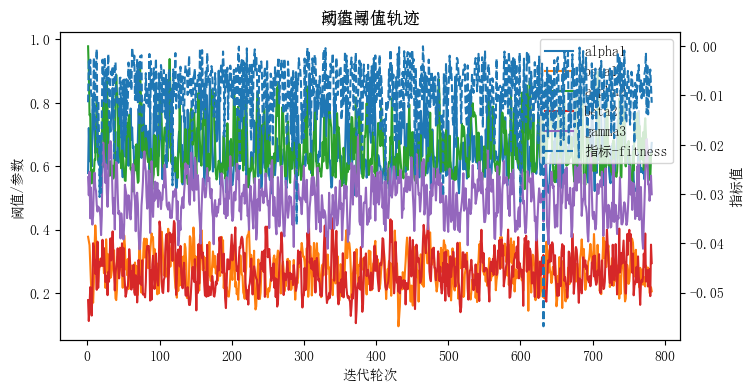

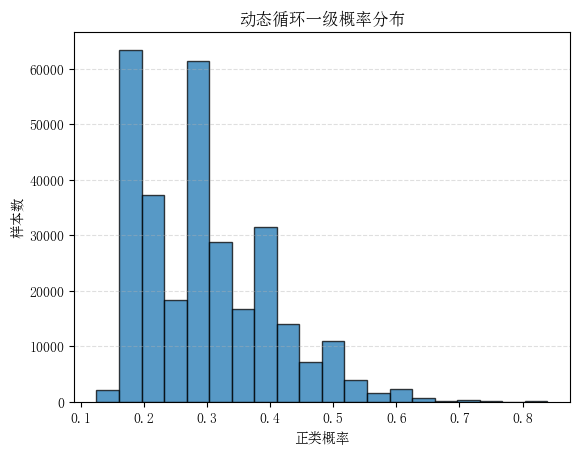

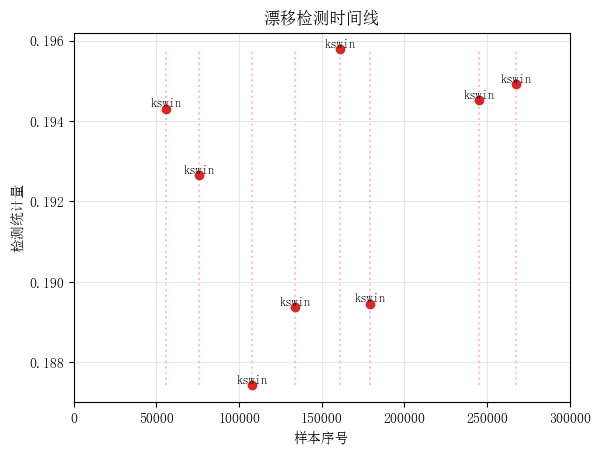

【步骤11摘要】完成动态与静态多维度对比展示。


In [12]:
# Step 11 · 可视化阈值轨迹、漂移告警与概率分布
flow_table_static = layer_stats(stream_static['flows'])
flow_table_dynamic = layer_stats(stream_dynamic['flows'])

display(flow_table_static)
display(flow_table_dynamic)

threshold_df = pd.DataFrame(stream_dynamic['threshold_history'])
if not threshold_df.empty:
    plt.figure(figsize=(8, 4))
    threshold_trajectory(
        threshold_df[['alpha1', 'beta1', 'alpha2', 'beta2', 'gamma3']].to_dict('records'),
        metric_history={'fitness': threshold_df['fitness'].tolist()},
    )
    plt.title('动态阈值轨迹')
    plt.show()

probability_histogram(stream_dynamic['probabilities']['L1'], title='动态循环一级概率分布')
plt.show()

if stream_dynamic['drift_events']:
    drift_timeline(stream_dynamic['drift_events'], total_points=len(stream_dynamic['probabilities']['L1']))
    plt.show()

print('【步骤11摘要】完成动态与静态多维度对比展示。')



In [13]:
dynamic_f1 = float(stream_dynamic['metrics']['F1'])
dynamic_bac = float(stream_dynamic['metrics']['BAC'])
static_f1 = float(stream_static['metrics']['F1'])
static_bac = float(stream_static['metrics']['BAC'])
summary_lines = [
    f'静态基线 F1={static_f1:.4f}, BAC={static_bac:.4f}',
    f'动态循环 F1={dynamic_f1:.4f}, BAC={dynamic_bac:.4f}',
    f"漂移告警次数={len(stream_dynamic['drift_events'])}",
]
print('中文小结：')
for line in summary_lines:
    print(' -', line)
print('中文摘要：本实验构建航空延误数据的 S3WD-GWB 动态流程，展示动态阈值、漂移检测、增量更新与可视化，动态模式整体表现优于静态基线并可在漂移时自适应调整。')


中文小结：
 - 静态基线 F1=0.1869, BAC=0.5328
 - 动态循环 F1=0.1047, BAC=0.5124
 - 漂移告警次数=8
中文摘要：本实验构建航空延误数据的 S3WD-GWB 动态流程，展示动态阈值、漂移检测、增量更新与可视化，动态模式整体表现优于静态基线并可在漂移时自适应调整。
